#### Import the libraries

In [1]:
# For cleaning and preparing the dataset
# -> dataframe manipulation
# -> text manipulation
# -> Web Scrapping

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re

import random


# Module to serialize the content produced from the execution of the code

import pickle


# Module to monitor the progress of a python for loop

from tqdm import tqdm


# Module to manipulate text in python - NLTK package

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


# Module to compute word vectorizers and compute the cosine distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

#### Keras Text Classification (For creating the word embeddings)

In [11]:
from nltk.stem import WordNetLemmatizer

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from time import time

#--------------------------------------------------------------

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#---------------------------------------------------------------

import matplotlib.pyplot as plt
from pylab import rcParams

import pydot
import pydotplus
import graphviz

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json

#Visualize Model

def visualize_model(model):
    return SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

from tensorflow.keras.utils import plot_model

#### Import the dataset

In [3]:
# dataset = pd.read_pickle('dataset_part_2_07112019.pkl') # previous version "dataset_30102019.pkl"
dataset = pd.read_pickle('dataset_part_2_25122019.pkl')

empty_list_tv = []

# On 07.11.2019 I noticed that some titles in my dataset had the words "TV-Mini Series" & "TV Movies" thus I decided to remove them

# In order for the change to take effect I should retrain the Keras Classifiers again!

for i in dataset['Movie Title']:
    if 'TV' in i: 
        empty_list_tv.append(i)
    else:
        pass

print("The number of the rows that are TV productions is: {}".format(len(empty_list_tv)))

print("\nThus, the 463 rows (movies) should be deleted since I don't want my algorithm to propose TV Series or TV Movies!")

dataset = dataset[~dataset['Movie Title'].isin(empty_list_tv)]

# Split the y variable ("Genres") to one hot encoded columns
mlb = MultiLabelBinarizer()
dataset = dataset.join(pd.DataFrame(mlb.fit_transform(dataset['Genres']),
                                    columns=mlb.classes_,
                                    index=dataset.index))

print("\nThe shape of the dataset that will be used in Keras classifier is: {}".format(dataset.shape))

dataset.head()

The number of the rows that are TV productions is: 463

Thus, the 463 rows (movies) should be deleted since I don't want my algorithm to propose TV Series or TV Movies!

The shape of the dataset that will be used in Keras classifier is: (10139, 39)


,Movie Title,IMDB Url,IMDB Rating,Actors,Director,Plot Summary,Plot Keywords,Genres,Movie Synopsis,Movie Synopsis Text,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,7.8,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,A paraplegic Marine dispatched to the moon Pan...,"[avatar, future, marine, native, paraplegic]","[Action, Adventure, Fantasy]",http://www.imdb.com/title/tt0499549/plotsummar...,The story opens with a sweeping shot high acro...,...,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,7.1,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...",Gore Verbinski,Captain Barbossa Will Turner and Elizabeth Swa...,"[goddess, marriage, ceremony, marriage, propos...","[Action, Adventure, Fantasy]",http://www.imdb.com/title/tt0449088/plotsummar...,To increase his and the East India Trading Com...,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,6.8,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Sam Mendes,A cryptic message from 007's past sends him pi...,"[bomb, espionage, sequel, spy, terrorist]","[Action, Adventure, Thriller]",http://www.imdb.com/title/tt2379713/plotsummar...,It looks like we don't have a Synopsis for thi...,...,0,0,0,0,0,0,0,1,0,0
3,The Dark Knight Rises,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,8.4,"[Christian Bale, Gary Oldman, Tom Hardy, Josep...",Christopher Nolan,Eight years after the Joker's reign of anarchy...,"[deception, imprisonment, lawlessness, police,...","[Action, Thriller]",http://www.imdb.com/title/tt1345836/plotsummar...,Commissioner James Gordon (Gary Oldman) is del...,...,0,0,0,0,0,0,0,1,0,0
4,John Carter,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,6.6,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...",Andrew Stanton,Transported to Barsoom a Civil War vet discove...,"[alien, american, civil, war, male, nipple, ma...","[Action, Adventure, Sci-Fi]",http://www.imdb.com/title/tt0401729/plotsummar...,"In New York City, 1881, a man eludes another i...",...,0,0,0,1,0,0,0,0,0,0


#### Understand the dependent variable: Genres of each movie

The label of each Genre (one hot encoded):


   Action  Adult  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0       1      0          1          0          0       0      0            0   
1       1      0          1          0          0       0      0            0   
2       1      0          1          0          0       0      0            0   
3       1      0          0          0          0       0      0            0   
4       1      0          1          0          0       0      0            0   

   Drama  Family  ...  News  Reality-TV  Romance  Sci-Fi  Short  Sport  \
0      0       0  ...     0           0        0       0      0      0   
1      0       0  ...     0           0        0       0      0      0   
2      0       0  ...     0           0        0       0      0      0   
3      0       0  ...     0           0        0       0      0      0   
4      0       0  ...     0           0        0       1      0      0   

   Talk-Show  Thriller 

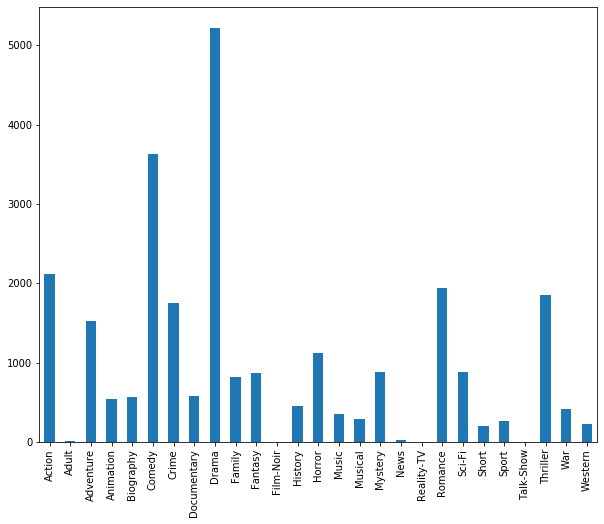

In [4]:
genre_labels = dataset[['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                        'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 
                        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]

print("The label of each Genre (one hot encoded):")
print('\n')
print(genre_labels.head())

print("\n---------------------------------------------------------------------------------")

print('\nThe distribution of the genre labels (frequency plot)')
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10

fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size

genre_labels.sum(axis=0).plot.bar()

y_labels = np.argmax(genre_labels.values, axis=1)

In [5]:
genre_labels.iloc[3]

Action         1
Adult          0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
Film-Noir      0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
News           0
Reality-TV     0
Romance        0
Sci-Fi         0
Short          0
Sport          0
Talk-Show      0
Thriller       1
War            0
Western        0
Name: 3, dtype: int32

#### Pickle the unique genre tags for later use

In [6]:
# unique_genres = genre_labels.columns.tolist()

# len(unique_genres)

# with open('genres_list_10112019.pkl', 'wb') as f:
#     pickle.dump(unique_genres, f)

In [7]:
with open('C:\\Users\\spano\\Desktop\\GitHub-Thesis\\pickled data\\genres_list_10112019.pkl', 'rb') as f:
    genres_list = pickle.load(f)

#### Create a random sequence of numbers to make predictions (used later)

In [8]:
random_numbers = random.sample(range(1, 2028), 5)

save_index_of_numbers = random_numbers

print("Randomly saved numbers to make predictions: {}".format(save_index_of_numbers))

Randomly saved numbers to make predictions: [295, 550, 352, 1530, 356]


#### Functions

In [25]:
# Class 1

class Keras_Configurations_model1():
    
        MAX_FEATURES = 20000
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2
    
class Keras_Configurations_model2():
        
        MAX_FEATURES = 17500
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2
        
class Keras_Configurations_model3():
        
        MAX_FEATURES = 20000
        BATCH_SIZE = 32
        NB_EPOCHS = 5
        EMB_DIMENSIONS = 100
        TARGET_LABELS = 27
        VERBOSE = 2

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Class 2

class Callback_Configurations():
    
    MONITOR_METRIC = 'val_loss'
    PATIENCE = 3
    VERBOSE = 1

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 1

def predict_genre_tags(indx, model):
    
    test_sequence = X_test_seq[indx:indx+1]
    
    text_prediction = model.predict(test_sequence)
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return predicted_tags

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 2

def inference_function(indx, model, x_test_seq, x_test, genres_list):
    
    test_sequence = x_test_seq[indx:indx+1]
    
    text_prediction = model.predict(test_sequence)
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return print('\n\nMovie Title: {}'.format(x_test['Movie Title'].iloc[indx]), '\n\nPredicted Genre labels: {}'.format(predicted_tags), '\n\nWith predicted probabilities: {}'.format(tag_probabilities), '\n\nThe actual Genre labels: {}'.format(x_test['Genres'].iloc[indx]), "\n\n", "---------------------------------------------------------------------------------------------------------")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 3

def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    
    no_stopword_text = [word for word in text.split(' ') if not word in stop_words]
    
    lemmatized_text = [lemmatizer.lemmatize(word, pos='v') for word in no_stopword_text]
    
    lowercase_text = [word.lower() for word in lemmatized_text]
    
    return ' '.join(lowercase_text)

def transform_actors(actors_column, dataset):
    
    actors_list = []

    for i in range(len(actors_column)):
        actors_list.append([element.lower() for element in actors_column.iloc[i]])

    dataset.loc[:, 'clean_actors'] = actors_list

def transform_plot(column_name):
    
    stop_words = set(stopwords.words('english'))

    lemmatizer = WordNetLemmatizer()
    
    dataset.loc[:, 'clean_plot_summary'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))

def transform_features(column_name):
    
    dataset.loc[:, 'clean_combined_features'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 4

def split_dataset(column_name, labels, dataset):
    
    X = dataset[['Movie Title', column_name, 'Genres']]
    y = labels # genre_labels.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    return X_train, X_test, y_train, y_test

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 5

def keras_tokenization(variable, x_train, x_test):
    
    if variable == "actors":

        actors_tokenizer = Tokenizer(num_words=Keras_Configurations_model1.MAX_FEATURES, lower=True, split=',', oov_token = '<OOV>')
    
        actors_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_actors']))

        actors_tokenizer.word_index = {e:i for e,i in actors_tokenizer.word_index.items() if i <= Keras_Configurations_model1.MAX_FEATURES}
    
        actors_tokenizer.word_index[actors_tokenizer.oov_token] = Keras_Configurations_model1.MAX_FEATURES + 1

        x_train.loc[:, 'actors_seqs'] = actors_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_actors'])
    
        x_test.loc[:, 'actors_seqs'] = actors_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_actors'])

        vocabulary_size_frequent_words = len(actors_tokenizer.word_index) + 1
        
        tokenizer = actors_tokenizer
            
    elif variable == "plot":
        
        plot_tokenizer = Tokenizer(num_words=Keras_Configurations_model2.MAX_FEATURES, lower=True, split=' ', oov_token = '<OOV>')
        
        plot_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_plot_summary']))

        plot_tokenizer.word_index = {e:i for e,i in plot_tokenizer.word_index.items() if i <= Keras_Configurations_model2.MAX_FEATURES}
        
        plot_tokenizer.word_index[plot_tokenizer.oov_token] = Keras_Configurations_model2.MAX_FEATURES + 1

        x_train.loc[:, 'plot_summary_seqs'] = plot_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_plot_summary'])
        
        x_test.loc[:, 'plot_summary_seqs'] = plot_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_plot_summary'])

        vocabulary_size_frequent_words = len(plot_tokenizer.word_index) + 1
        
        tokenizer = plot_tokenizer
        
    elif variable == "features":
        
        combined_features_tokenizer = Tokenizer(num_words=Keras_Configurations_model3.MAX_FEATURES, lower=True, split=' ', oov_token = '<OOV>')
        
        combined_features_tokenizer.fit_on_texts(list(x_train.loc[:, 'clean_combined_features']))

        combined_features_tokenizer.word_index = {e:i for e,i in combined_features_tokenizer.word_index.items() if i <= Keras_Configurations_model3.MAX_FEATURES}
        
        combined_features_tokenizer.word_index[combined_features_tokenizer.oov_token] = Keras_Configurations_model3.MAX_FEATURES + 1

        x_train.loc[:, 'combined_features_seqs'] = combined_features_tokenizer.texts_to_sequences(x_train.loc[:, 'clean_combined_features'])
        
        x_test.loc[:, 'combined_features_seqs'] = combined_features_tokenizer.texts_to_sequences(x_test.loc[:, 'clean_combined_features'])

        vocabulary_size_frequent_words = len(combined_features_tokenizer.word_index) + 1
        
        tokenizer = combined_features_tokenizer
        
    return vocabulary_size_frequent_words, tokenizer

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 6

def padding_sequnce_length(variable, x_train):
    
    if variable == "actors":
    
        all_train_lengths =  list(x_train.actors_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of the pad sequence for Actors: {}\n'.format(maxlen))
        
    elif variable == "plot":
        
        all_train_lengths = list(x_train.plot_summary_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of each padding sequence for Plot summary text: {}\n'.format(maxlen))
        
    elif variable == "features":
        
        all_train_lengths =  list(x_train.combined_features_seqs.apply(len))

        maxlen = int(np.percentile(all_train_lengths, q=90))

        print('Max Length of each padding sequence for Movie features text: {}\n'.format(maxlen))
        
    return maxlen

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 7

# the input data for a deep learning model must be a single tensor (of shape e.g. (batch_size, 6, vocab_size) in this case), 
# samples that are shorter than the longest item need to be padded with some placeholder value.

#url https://www.tensorflow.org/guide/keras/masking_and_padding
def padding_sequence(variable, x_train, x_test, y_train, y_test, maxlen):
    
    if variable == "actors":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'actors_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'actors_seqs'], padding='post', maxlen=maxlen)
        
        #--------------------------------------------------------------------
        
        # Task 1: Discussed with Mr. Louridas
        
        #padded_shapes = ([100], [None]) # ([None],())
        
        #x_train_seq = x_train.values.shuffle(1000).padded_batch(32, padded_shapes = padded_shapes) # shuffle is the length of the longest string
        #x_test_seq = x_test.values.shuffle(1000).padded_batch(32, padded_shapes = padded_shapes)

        #--------------------------------------------------------------------
        
        assert len(x_train_seq) == len(y_train) # x_train_seq

        assert len(x_test_seq) == len(y_test) # x_test_seq
        
    elif variable == "plot":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'plot_summary_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'plot_summary_seqs'], padding='post', maxlen=maxlen)

        assert len(x_train_seq) == len(y_train)

        assert len(x_test_seq) == len(y_test)
        
    elif variable == "features":
        
        x_train_seq = pad_sequences(x_train.loc[:, 'combined_features_seqs'], padding='post', maxlen=maxlen)
    
        x_test_seq = pad_sequences(x_test.loc[:, 'combined_features_seqs'], padding='post', maxlen=maxlen)

        assert len(x_train_seq) == len(y_train)

        assert len(x_test_seq) == len(y_test)
        
    return x_train_seq, x_test_seq

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 8

def keras_multy_classification_model():
    
    sentenceLength_actors = 15
    vocab_size_frequent_words_actors = 20001
    
    sentenceLength_plot = 23
    vocab_size_frequent_words_plot = 17501
    
    sentenceLength_features = 69
    vocab_size_frequent_words_features = 20001
    
    model = keras.Sequential(name='Multy-Input Keras Classification model')
    
    actors = keras.Input(shape=(sentenceLength_actors,), name='actors_input')
    plot = keras.Input(shape=(sentenceLength_plot,), name='plot_input')
    features = keras.Input(shape=(sentenceLength_features,), name='features_input')
    
    emb1 = layers.Embedding(input_dim = vocab_size_frequent_words_actors + 1,
                            # based on keras documentation input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
                            output_dim = Keras_Configurations_model1.EMB_DIMENSIONS,
                            # int >= 0. Dimension of the dense embedding
                            embeddings_initializer = 'uniform', 
                            # Initializer for the embeddings matrix.
                            mask_zero = False,
                            input_length = sentenceLength_actors,
                            name="actors_embedding_layer")(actors)
    encoded_layer1 = layers.LSTM(100)(emb1)
    
    emb2 = layers.Embedding(input_dim = vocab_size_frequent_words_plot + 1,
                            output_dim = Keras_Configurations_model2.EMB_DIMENSIONS,
                            embeddings_initializer = 'uniform',
                            mask_zero = False,
                            input_length = sentenceLength_plot,
                            name="plot_embedding_layer")(plot)
    encoded_layer2 = layers.LSTM(100)(emb2)
    
    emb3 = layers.Embedding(input_dim = vocab_size_frequent_words_features + 1,
                            output_dim = Keras_Configurations_model3.EMB_DIMENSIONS,
                            embeddings_initializer = 'uniform',
                            mask_zero = False,
                            input_length = sentenceLength_features,
                            name="features_embedding_layer")(features)
    encoded_layer3 = layers.LSTM(100)(emb3)
    
    merged = layers.concatenate([encoded_layer1, encoded_layer2, encoded_layer3], axis=-1)

    #flatten_1 = model.add(layers.Flatten())(merged)
    #flatten_1 = keras.layers.Add(Flatten())(merged)

    layer_1 = layers.Dense(Keras_Configurations_model1.BATCH_SIZE, activation='relu')(merged)
    
    output_layer = layers.Dense(Keras_Configurations_model1.TARGET_LABELS, activation='softmax')(layer_1)
    
    model = keras.Model(inputs=[actors, plot, features], outputs=output_layer)
    
    print(model.output_shape)

    print(model.summary())

    model.compile(optimizer='adam', #rmsprop
                  loss='sparse_categorical_crossentropy', # categorical_crossentropy
                  metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy, acc
    
    plot_model(model, to_file='model.png')
    
    return model


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 9

def callback(saved_model, model):
    
    weights_fname = '{}'.format(saved_model)
    
    # C:\\Users\\spano\\Desktop\\GitHub-Thesis\\keras_models\\{}

    try:
        model.load_weights(weights_fname)
    except:
        print('\nPre-trained weights not found. Fitting from start')
        pass

    monitor_metric = Callback_Configurations.MONITOR_METRIC
    
    callbacks = [
        EarlyStopping(monitor=monitor_metric,
                      patience=Callback_Configurations.PATIENCE,
                      verbose=Callback_Configurations.VERBOSE,
                      restore_best_weights=True),

        ModelCheckpoint(filepath=weights_fname,
                        monitor=monitor_metric,
                        verbose=Callback_Configurations.VERBOSE,
                        save_best_only=True,
                        save_weights_only=True) #True
]
    return callbacks

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 10

def fit_keras_multy_input(model, x_train_seq_actors, x_train_seq_plot, x_train_seq_features, x_test_seq_actors, x_test_seq_plot, x_test_seq_features, y_train, y_test):
    
    s = time()

    fit_model = model.fit([x_train_seq_actors, x_train_seq_plot, x_train_seq_features], y_train, 
                          epochs=Keras_Configurations_model1.NB_EPOCHS,
                          verbose = Keras_Configurations_model1.VERBOSE,
                          batch_size=Keras_Configurations_model1.BATCH_SIZE,
                          validation_data=([x_test_seq_actors, x_test_seq_plot, x_test_seq_features], y_test),
                          callbacks=callbacks)

    duration = time() - s
    print("\nTraining time finished. Duration {} secs".format(duration))
    
    return fit_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 11

def save_model(model, model_name):
    
    model_json = model.to_json()

    with open("{}.json".format(model_name), "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights("{}.h5".format(model_name))
    
    print("\nModel's weights are saved")

#### Model 4: Multy-Input sequential model

In [26]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Transfrom the columns
print("---------------------------------------------------------------------------------\n")
print("Transfrom the column of the actors\n")

transform_actors(dataset.loc[:, "Actors"], dataset) # function 3: transform_actors

print("Transfrom the column of the plot summary\n")
transform_plot("Plot Summary") # function 3: transform_plot

print("Transfrom the column of the movie features\n")
transform_features("Combined_Features") # function 3: transform_features

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Split the dataset into train & validation set
print("\n---------------------------------------------------------------------------------")
print("\nSplit the dataset into train & validation set\n")

print("\nActors Train & Validation\n")
X_train_actors, X_test_actors, y_train, y_test = split_dataset('clean_actors', y_labels, dataset) # function 4: split_dataset # genre_labels.values

print("\nPlot Summary Train & Validation\n")
X_train_plot, X_test_plot, y_train, y_test = split_dataset('clean_plot_summary', y_labels, dataset) # function 4: split_dataset

print("\nMovie Features Train & Validation\n")
X_train_features, X_test_features, y_train, y_test = split_dataset('clean_combined_features', y_labels, dataset) # function 4: split_dataset

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Tokenize the dataset (using the keras tokenizer)
print("\n---------------------------------------------------------------------------------")
print("\nTokenize the dataset (using the keras tokenizer)\n")

print("\nActors tokenized\n")
vocabulary_size_frequent_words_actors, tokenizer_actors = keras_tokenization("actors", X_train_actors, X_test_actors) # function 5: keras_tokenization

print("\nPlot Summary tokenized\n")
vocabulary_size_frequent_words_plot, tokenizer_plot = keras_tokenization("plot", X_train_plot, X_test_plot) # function 5: keras_tokenization

print("\nMovie Features tokenized\n")
vocabulary_size_frequent_words_features, tokenizer_features = keras_tokenization("features", X_train_features, X_test_features) # function 5: keras_tokenization

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Specify the length of the maxlen variable
print("\n---------------------------------------------------------------------------------")
print("\nSpecify the length of the maxlen variable (length is a parameter for the optimal padding execution)\n")

maxlen_actors = padding_sequnce_length("actors", X_train_actors) # function 6: padding_sequnce_length
maxlen_plot = padding_sequnce_length("plot", X_train_plot) # function 6: padding_sequnce_length
maxlen_features = padding_sequnce_length("features", X_train_features) # function 6: padding_sequnce_length

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Create the padding sequence of texts
print("\n---------------------------------------------------------------------------------")
print("\nCreate the padding sequence of texts\n")

X_train_seq_actors, X_test_seq_actors = padding_sequence("actors", X_train_actors, X_test_actors, y_train, y_test, maxlen_actors) # function 7: padding_sequence
X_train_seq_plot, X_test_seq_plot = padding_sequence("plot", X_train_plot, X_test_plot, y_train, y_test, maxlen_plot) # function 7: padding_sequence
X_train_seq_features, X_test_seq_features = padding_sequence("features", X_train_features, X_test_features, y_train, y_test, maxlen_features) # function 7: padding_sequence

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Setting the Keras Classification Model
print("\n---------------------------------------------------------------------------------")
print("\nCreate the Keras Classification Model\n")

model_4 = keras_multy_classification_model() # function 8: kera_classification_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Creating a callback function to save the model when a better validation loss is achieved
print("\n---------------------------------------------------------------------------------")
print("\nEnsemble a callback function")  # function 9: callback

callbacks = callback("model_multy_input.h5", model_4)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Fitting the Keras classification model on the train dataset
print("\n---------------------------------------------------------------------------------")
print("\nFit the keras classification model")

fit_model = fit_keras_multy_input(model_4, X_train_seq_actors, X_train_seq_plot, X_train_seq_features, X_test_seq_actors, X_test_seq_plot, X_test_seq_features, y_train, y_test) # function 10: fit_keras

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Save the trained model
print("\n---------------------------------------------------------------------------------")
print("\nSave the Model")

save_model(model_4, "model_multy_input") # function 11: save_model

---------------------------------------------------------------------------------

Transfrom the column of the actors

Transfrom the column of the plot summary

Transfrom the column of the movie features


---------------------------------------------------------------------------------

Split the dataset into train & validation set


Actors Train & Validation


Plot Summary Train & Validation


Movie Features Train & Validation


---------------------------------------------------------------------------------

Tokenize the dataset (using the keras tokenizer)


Actors tokenized


Plot Summary tokenized


Movie Features tokenized


---------------------------------------------------------------------------------

Specify the length of the maxlen variable (length is a parameter for the optimal padding execution)

Max Length of the pad sequence for Actors: 15

Max Length of each padding sequence for Plot summary text: 23

Max Length of each padding sequence for Movie features text: 69




#### Functions (Continued)

In [27]:
# Function 12

# How should I extract the word embeddings for each of the three inputs?

# Option 1: Use each different embedding layer?
# Option 2: Use the concatenated layer?

def extract_word_embeddings_multiple_inputs(variable, model, tokenizer):

    embeddings_actors = model.layers[3].get_weights()[0]
    
    embeddings_plot = model.layers[4].get_weights()[0]
    
    embeddings_features = model.layers[5].get_weights()[0]
    
    if variable == "actors":

        word_embeddings = {w:embeddings_actors[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model1.MAX_FEATURES+1}
        
    elif variable == "plot":

        word_embeddings = {w:embeddings_plot[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model2.MAX_FEATURES+1}
        
    elif variable == "features":

        word_embeddings = {w:embeddings_features[idx] for w, idx in tokenizer.word_index.items() if idx <= Keras_Configurations_model3.MAX_FEATURES+1}
        
    return word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 13

def assign_word_embeddings(variable, dataset, word_embeddings):
    
    if variable == "actors":
    
        average_vector_list_cast = []

        min_vector_list_cast = []

        max_vector_list_cast = []

        actors_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
            
            actors = dataset.loc[:, "clean_actors"].iloc[i]
    
            assert [word.islower() for word in actors] # assert that all actors are present in lower case
    
            actors_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in actors])
    
        dataset.loc[:, 'actors_embeddings_list'] = actors_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            actor_embeddings = dataset["actors_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in actor_embeddings], axis=0)
            maximum = np.max([element for element in actor_embeddings], axis=0)
            average = np.mean([element for element in actor_embeddings], axis=0)
    
            min_vector_list_cast.append(minimum)
            max_vector_list_cast.append(maximum)
            average_vector_list_cast.append(average)

        dataset['minimum_cast_vectors'] = min_vector_list_cast
        dataset['maximum_cast_vectors'] = max_vector_list_cast
        dataset['average_cast_vectors'] = average_vector_list_cast
        
    elif variable == "plot":
    
        average_vector_list_plot = []

        min_vector_list_plot = []

        max_vector_list_plot = []

        plot_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
            
            plot = dataset["clean_plot_summary"].iloc[i]
    
            plot_split = plot.split(' ')
    
            assert [word.islower() for word in plot_split]
    
            plot_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in plot_split])
    
        dataset['plot_embeddings_list'] = plot_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            plot_embeddings = dataset["plot_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in plot_embeddings], axis=0)
            maximum = np.max([element for element in plot_embeddings], axis=0)
            average = np.mean([element for element in plot_embeddings], axis=0)
    
            min_vector_list_plot.append(minimum)
            max_vector_list_plot.append(maximum)
            average_vector_list_plot.append(average)

        dataset['minimum_plot_vectors'] = min_vector_list_plot
        dataset['maximum_plot_vectors'] = max_vector_list_plot
        dataset['average_plot_vectors'] = average_vector_list_plot
        
    elif variable == "features":
    
        average_vector_list_combined_features = []

        min_vector_list_combined_features = []

        max_vector_list_combined_features = []

        combined_features_embeddings_list = []

        for i in tqdm(range(len(dataset.index))):
    
            combined_features = dataset["clean_combined_features"].iloc[i]
    
            combined_features_split = combined_features.split(' ')
    
            assert [word.islower() for word in combined_features_split]
    
            combined_features_embeddings_list.append([word_embeddings[word] if word in word_embeddings else word_embeddings['<OOV>'] for word in combined_features_split])
    
        dataset['combined_features_embeddings_list'] = combined_features_embeddings_list

        for i in tqdm(range(len(dataset.index))):
            
            combined_features_embeddings = dataset["combined_features_embeddings_list"].iloc[i]
    
            minimum = np.min([element for element in combined_features_embeddings], axis=0)
            maximum = np.max([element for element in combined_features_embeddings], axis=0)
            average = np.mean([element for element in combined_features_embeddings], axis=0)
    
            min_vector_list_combined_features.append(minimum)
            max_vector_list_combined_features.append(maximum)
            average_vector_list_combined_features.append(average)

        dataset['minimum_combined_features_vectors'] = min_vector_list_combined_features
        dataset['maximum_combined_features_vectors'] = max_vector_list_combined_features
        dataset['average_combined_features_vectors'] = average_vector_list_combined_features
        
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 14

def evaluate_keras_model(model, x_test_seq_actors, x_test_seq_plot, x_test_seq_features, y_test):
    
    model.compile(optimizer='adam', #rmsprop
    loss='sparse_categorical_crossentropy', # categorical_crossentropy
    metrics=['sparse_categorical_accuracy'])
        
    score = model.evaluate([x_test_seq_actors, x_test_seq_plot, x_test_seq_features], y_test, verbose=0)

    print('\nTest Score:', score[0])

    print('\nTest Accuracy:', score[1])
    
    return score

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 15

def plot_model_metrics(fit_model):

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['sparse_categorical_accuracy'] , 'g') # acc
    plt.plot(fit_model.history['val_sparse_categorical_accuracy'] , 'b') # val_acc
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['loss'] , 'g')
    plt.plot(fit_model.history['val_loss'] , 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()


---------------------------------------------------------------------------------

Extract the word embeddings

Word embeddings for actors extracted


Word embeddings for plot summary extracted


Word embeddings for movie features extracted


---------------------------------------------------------------------------------

Assign the word embeddings to each different word


100%|██████████████████████████████████████████████████████████████████████████| 10139/10139 [00:01<00:00, 7745.89it/s]



---------------------------------------------------------------------------------
Evaluate the classification model

Test Score: 0.8660868061835009

Test Accuracy: 0.86193293

---------------------------------------------------------------------------------

Plot the model's accuracy & loss


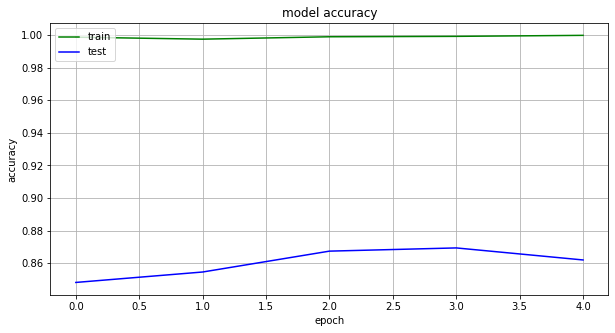

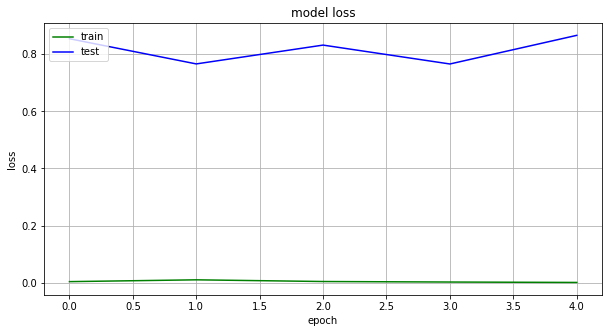

In [28]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Extract the word embeddings
print("\n---------------------------------------------------------------------------------")
print("\nExtract the word embeddings")

with open('model_multy_input.json','r') as f:
    model_json = json.load(f)

model_4 = model_from_json(model_json)

model_4.load_weights('model_multy_input.h5')

word_embeddings_actors = extract_word_embeddings_multiple_inputs("actors", model_4, tokenizer_actors) # function 12: extract_word_embeddings
print("\nWord embeddings for actors extracted\n")

word_embeddings_plot = extract_word_embeddings_multiple_inputs("plot", model_4, tokenizer_plot) # function 12: extract_word_embeddings
print("\nWord embeddings for plot summary extracted\n")

word_embeddings_features = extract_word_embeddings_multiple_inputs("features", model_4, tokenizer_features) # function 12: extract_word_embeddings
print("\nWord embeddings for movie features extracted\n")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Assign the word embeddings to each different actor
print("\n---------------------------------------------------------------------------------")
print("\nAssign the word embeddings to each different word")

assign_word_embeddings("actors", dataset, word_embeddings_actors) # function 13: assign_word_embeddings

assign_word_embeddings("plot", dataset, word_embeddings_plot) # function 13: assign_word_embeddings

assign_word_embeddings("features", dataset, word_embeddings_features) # function 13: assign_word_embeddings

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluate the model
print("\n---------------------------------------------------------------------------------")
print("Evaluate the classification model")

score = evaluate_keras_model(model_4, X_test_seq_actors, X_test_seq_plot, X_test_seq_features, y_test) # function 14: evaluate_keras_model

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Plot keras model accuracy & loss
print("\n---------------------------------------------------------------------------------")
print("\nPlot the model's accuracy & loss")

plot_model_metrics(fit_model) # function 15: plot_model_metrics

# (To be completed!)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Predict the genre tags on new data
# print("\n---------------------------------------------------------------------------------")
# print("\nPredict the genre tags of new movie's actors")

# for i in save_index_of_numbers:
#     inference_function(i, model_1, X_test_seq, X_test, genres_list) # function 2: inference_function

#### Test-Accuracy Dataframe

In [61]:
df_scores = pd.DataFrame({'Keras Model':pd.Series(['Combined Features'], dtype='str'),
                         'Test Loss':pd.Series([score[0]], dtype='float'),
                         'Test Accuracy':pd.Series([score[1]], dtype='float')})

df_scores

,Keras Model,Test Loss,Test Accuracy
0,Combined Features,0.40157,0.881657


#### Predicted vs Actual Genre Tags

In [62]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test['Movie Title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model_3)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test['Genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers[0:])):

    df_predictions = df_predictions.append({'Movie Title' : X_test['Movie Title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags' : predict_genre_tags(save_index_of_numbers[i], model_3),
                                            'Real Genre tags': X_test['Genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions.drop(df_predictions.index[0])

,Movie Title,Predicted Genre tags,Real Genre tags
1,Otaku no video (Video 1991),"[Documentary, Drama, Short]","[Animation, Comedy, Drama]"
2,Vibes - Die Jagd nach der glühenden Pyramide,"[Action, Adventure, Comedy]","[Adventure, Comedy, Romance]"
3,In schlechter Gesellschaft,"[Adventure, Drama, Mystery]","[Adventure, Drama, Western]"
4,Rangoon,"[Action, Adventure, Crime]","[Action, Adventure, Drama]"
5,Liquid Sky,"[Crime, Drama, Horror]","[Sci-Fi, Thriller]"


In [29]:
dataset.columns

Index(['Movie Title', 'IMDB Url', 'IMDB Rating', 'Actors', 'Director',
       'Plot Summary', 'Plot Keywords', 'Genres', 'Movie Synopsis',
       'Movie Synopsis Text', 'Combined_Features', 'Actors_Embeddings',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', 'clean_actors', 'clean_plot_summary',
       'clean_combined_features', 'actors_embeddings_list',
       'minimum_cast_vectors', 'maximum_cast_vectors', 'average_cast_vectors',
       'plot_embeddings_list', 'minimum_plot_vectors', 'maximum_plot_vectors',
       'average_plot_vectors', 'combined_features_embeddings_list',
       'minimum_combined_features_vectors',
       'maximum_combined_features_vectors',
       'average_combined_features_vectors'],
      

In [30]:
dataset_with_embeddings = dataset[['Movie Title', 'IMDB Url', 'IMDB Rating', 'Actors', 'Plot Summary', 'Combined_Features', 'Genres', 'Movie Synopsis Text', 
                                   'clean_actors', 'clean_plot_summary', 'clean_combined_features',
                                   'actors_embeddings_list','minimum_cast_vectors', 'maximum_cast_vectors', 'average_cast_vectors', 
                                   'plot_embeddings_list', 'minimum_plot_vectors', 'maximum_plot_vectors', 'average_plot_vectors',
                                   'combined_features_embeddings_list', 'minimum_combined_features_vectors', 'maximum_combined_features_vectors','average_combined_features_vectors']]

dataset_with_embeddings.head()

,Movie Title,IMDB Url,IMDB Rating,Actors,Plot Summary,Combined_Features,Genres,Movie Synopsis Text,clean_actors,clean_plot_summary,...,maximum_cast_vectors,average_cast_vectors,plot_embeddings_list,minimum_plot_vectors,maximum_plot_vectors,average_plot_vectors,combined_features_embeddings_list,minimum_combined_features_vectors,maximum_combined_features_vectors,average_combined_features_vectors
0,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,7.8,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",A paraplegic Marine dispatched to the moon Pan...,avatar sam worthington zoe saldana sigourney w...,"[Action, Adventure, Fantasy]",The story opens with a sweeping shot high acro...,"[sam worthington, zoe saldana, sigourney weave...",a paraplegic marine dispatch moon pandora uniq...,...,"[0.11861045, 0.07107138, 0.04371799, 0.1851179...","[0.030557789, -0.05024977, -0.022204358, 0.003...","[[0.06500598, 0.04226752, -0.0055114185, 0.088...","[-0.15305574, -0.15927963, -0.13471632, -0.178...","[0.1685292, 0.15945148, 0.17454754, 0.17293082...","[-0.029695595, -0.005905897, 0.032873943, -0.0...","[[0.045727525, 0.100293286, -0.07586175, -0.07...","[-0.3035245, -0.65917146, -0.18394515, -0.1462...","[0.21925098, 0.11198816, 0.50976527, 0.3190763...","[0.0033384054, -0.012268523, 0.005842858, 0.00..."
1,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,7.1,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...",Captain Barbossa Will Turner and Elizabeth Swa...,pirates of the caribbean: at world's end johnn...,"[Action, Adventure, Fantasy]",To increase his and the East India Trading Com...,"[johnny depp, geoffrey rush, orlando bloom, ke...",captain barbossa will turner elizabeth swann m...,...,"[0.11991611, 0.069102146, 0.051403534, 0.11216...","[0.05442299, -0.05240816, -0.025088113, 0.0066...","[[-0.07404685, -0.10443978, 0.04856563, -0.049...","[-0.1269752, -0.14142519, -0.087827206, -0.110...","[0.044696014, 0.06553898, 0.19384372, 0.123332...","[-0.026009388, -0.02379885, 0.049902964, -0.03...","[[0.03500349, -0.01810979, -0.01091351, -0.071...","[-0.3035245, -0.65917146, -0.16848958, -0.1405...","[0.21925098, 0.17458713, 0.50976527, 0.3190763...","[-0.007304773, -0.010745064, -0.007580723, -0...."
2,Spectre,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,6.8,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",A cryptic message from 007's past sends him pi...,spectre daniel craig christoph waltz léa seydo...,"[Action, Adventure, Thriller]",It looks like we don't have a Synopsis for thi...,"[daniel craig, christoph waltz, léa seydoux, r...",a cryptic message 007's past send pit mysterio...,...,"[0.11991611, 0.040307432, 0.13142951, 0.078997...","[0.022088837, -0.04478245, -0.0010554981, -0.0...","[[0.06500598, 0.04226752, -0.0055114185, 0.088...","[-0.08922741, -0.08062133, -0.09203483, -0.082...","[0.082069226, 0.10016898, 0.116937086, 0.08875...","[-0.016339572, -0.010018364, 0.029128032, 2.28...","[[0.043624915, 0.036170643, -0.049008112, -0.0...","[-0.3035245, -0.65917146, -0.10666047, -0.1202...","[0.21925098, 0.12659177, 0.50976527, 0.3190763...","[-0.012811501, -0.013995357, 0.0052853418, -0...."
3,The Dark Knight Rises,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,8.4,"[Christian Bale, Gary Oldman, Tom Hardy, Josep...",Eight years after the Joker's reign of anarchy...,the dark knight rises christian bale gary oldm...,"[Action, Thriller]",Commissioner James Gordon (Gary Oldman) is del...,"[christian bale, gary oldman, tom hardy, josep...",eight years joker's reign anarchy batman help ...,...,"[0.11308055, 0.05720426, 0.09768567, 0.0521588...","[0.023476573, -0.045097508, 0.0021906407, -0.0...","[[-0.15346016, -0.11413462, 0.18223174, -0.103...","[-0.15346016, -0.11923429, -0.15251015, -0.103...","[0.068375796, 0.15945148, 0.18223174, 0.065413...","[0.00584147, 0.024257008, -0.015133594, 0.0027...","[[0.06749575, -0.014500051, 0.09179792, 0.0731...","[-0.1136329, -0.36967653, -0.

In [31]:
keras_embeddings_array_cast = np.hstack([dataset_with_embeddings['average_cast_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['minimum_cast_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['maximum_cast_vectors'].apply(pd.Series).values])

keras_embeddings_array_plot = np.hstack([dataset_with_embeddings['average_plot_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['minimum_plot_vectors'].apply(pd.Series).values,
                                         dataset_with_embeddings['maximum_plot_vectors'].apply(pd.Series).values])

keras_embeddings_array_combined_features = np.hstack([dataset_with_embeddings['average_combined_features_vectors'].apply(pd.Series).values,
                                                     dataset_with_embeddings['minimum_combined_features_vectors'].apply(pd.Series).values,
                                                     dataset_with_embeddings['maximum_combined_features_vectors'].apply(pd.Series).values])

keras_embeddings_array_cast_plot_combined_features = np.hstack([keras_embeddings_array_cast, 
                                                                keras_embeddings_array_plot, 
                                                                keras_embeddings_array_combined_features])

print("Shape of the Actors embeddings: {}".format(keras_embeddings_array_cast.shape))
print("\nShape of the Plot Summary embeddings: {}".format(keras_embeddings_array_plot.shape))
print("\nShape of the Combined Features embeddings: {}".format(keras_embeddings_array_combined_features.shape))
print("\nShape of the concatenated embeddings(cast, plot, combined features): {}".format(keras_embeddings_array_cast_plot_combined_features.shape))

Shape of the Actors embeddings: (10139, 300)

Shape of the Plot Summary embeddings: (10139, 300)

Shape of the Combined Features embeddings: (10139, 300)

Shape of the concatenated embeddings(cast, plot, combined features): (10139, 900)


In [32]:
with open('keras_embeddings_array_cast_27122019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_cast, f)
    
with open('keras_embeddings_array_plot_27122019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_plot, f)
    
with open('keras_embeddings_array_combined_features_27122019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_combined_features, f)
    
with open('keras_embeddings_array_cast_plot_features_27122019.pkl', 'wb') as f:
    pickle.dump(keras_embeddings_array_cast_plot_combined_features, f)

#### Pickle the dataset with the word embeddings

In [33]:
dataset_with_embeddings.to_pickle('dataset_part_3_27122019.pkl')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### From this part and below, I will need to discuss further steps with professor Louridas!

### Next Steps

* Visualize the movie title of a movie based on the trained words embeddings of plot, cast, combined features

* Hyperparameter tuning on the keras classification models

* Fine-tuning based on pretrained embeddings from GloVe

#### Visualize the distances among movie titles based on the trained embeddings

#### Plot Summary vectors

In [ ]:
# Word embeddings of the plot summary

plot_embeddings = []

for i in tqdm(range(len(dataset.index))):
    plot = dataset["clean_plot_summary"].iloc[i]
    
    movie_title = dataset["Movie Title"].iloc[i]
    
    plot_split = plot.split(' ')
    
    assert [word.islower() for word in plot_split]
    
    plot_embeddings.append([(movie_title, words_embeddings_plot[word]) if word in words_embeddings_plot else words_embeddings_plot['<OOV>'] for word in plot_split])

In [23]:
# Word embeddings of the plot summary

plot_embeddings = []

for i in tqdm(range(len(dataset.index))):
    plot = dataset["clean_plot_summary"].iloc[i]
    
    movie_title = dataset["Movie Title"].iloc[i]
    
    plot_split = plot.split(' ')
    
    assert [word.islower() for word in plot_split]
    
    plot_embeddings.append([(movie_title, words_embeddings_plot[item])for item in plot_split if item in words_embeddings_plot])

# item_vectors = [(item, words_embeddings_plot[item])for item in plot_split if item in words_embeddings_plot]

100%|█████████████████████████████████████████████████████████████████████████| 10602/10602 [00:00<00:00, 32925.73it/s]


In [21]:
# Word embeddings of the plot summary

plot_embeddings = [(item, words_embeddings_plot[item]) for item in dataset["clean_plot_summary"] if item in words_embeddings_plot]

In [26]:
plot_embeddings[1]

[("Pirates of the Caribbean: At World's End",
  array([ 0.04113564, -0.04406666, -0.0673745 , -0.00874797,  0.05740562,
         -0.13056004,  0.08970004, -0.13624181, -0.11925312,  0.16642973,
         -0.01914988,  0.08958084, -0.09654929,  0.14490011,  0.01095328,
          0.0547801 , -0.0524132 , -0.01776052, -0.05707503, -0.0052028 ,
         -0.08470128,  0.10677217, -0.04327436,  0.16428225, -0.05860477,
          0.01524828,  0.1252242 , -0.1381478 ,  0.07708687,  0.02625908,
         -0.09369349, -0.00790034, -0.02119448, -0.19022264, -0.18552704,
          0.00617033,  0.08651023, -0.15283695, -0.05706623, -0.09653908,
          0.04834247, -0.14848576,  0.14884463, -0.24576586,  0.17710187,
         -0.05304932,  0.05875471, -0.12259176,  0.06352759,  0.12022086,
         -0.20089743,  0.01504979, -0.05595682, -0.20771545, -0.03411673,
         -0.07865473, -0.04425288, -0.07212084,  0.13362814, -0.07960351,
          0.06212578, -0.09676912,  0.09223007, -0.05978144,  0.06

In [28]:
from sklearn.manifold import TSNE

vectors = np.asarray([x[0][1] for x in plot_embeddings])

lengths = np.linalg.norm(vectors, axis = 1)

norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components = 2, perplexity=1, verbose = 2).fit_transform(norm_vectors)

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 10602 samples in 0.099s...
[t-SNE] Computed neighbors for 10602 samples in 7.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10602
[t-SNE] Computed conditional probabilities for sample 2000 / 10602
[t-SNE] Computed conditional probabilities for sample 3000 / 10602
[t-SNE] Computed conditional probabilities for sample 4000 / 10602
[t-SNE] Computed conditional probabilities for sample 5000 / 10602
[t-SNE] Computed conditional probabilities for sample 6000 / 10602
[t-SNE] Computed conditional probabilities for sample 7000 / 10602
[t-SNE] Computed conditional probabilities for sample 8000 / 10602
[t-SNE] Computed conditional probabilities for sample 9000 / 10602
[t-SNE] Computed conditional probabilities for sample 10000 / 10602
[t-SNE] Computed conditional probabilities for sample 10602 / 10602
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.113s
[t-SNE] Iteration 50: error = 166.470

In [30]:
x = tsne[:,0]
y = tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(plot_embeddings, x, y):
    ax.annotate(item[0][0], (x1, y1))
    
plt.show()

KeyboardInterrupt: 

#### End of part 3 (Keras Text Classification & Word Embeddings)